Data Preparation

In [43]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Load data (same as ARIMA notebook)
df = pd.read_parquet("../data/processed/model_ready.parquet")
aapl = df[df['ticker'] == 'AAPL'][['close']]

# Normalize data to [0,1] (critical for LSTMs)
scaler = MinMaxScaler()
aapl_scaled = scaler.fit_transform(aapl)

# Create sequences for LSTM (e.g., 30 days → predict next day)
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data)-window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(aapl_scaled)
print(f"X shape: {X.shape}, y shape: {y.shape}")  # Should be (n_samples, 30, 1)



X shape: (307, 30, 1), y shape: (307, 1)


 Build LSTM Model

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(30, 1)),  # 30-day window
    Dropout(0.2),  # Prevents overfitting
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()  # Verify architecture



C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Train the Model

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.2764 - val_loss: 0.0721
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0469 - val_loss: 0.0151
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0167 - val_loss: 0.0187
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0108 - val_loss: 0.0160
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0090 - val_loss: 0.0112
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0069 - val_loss: 0.0112
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0062 - val_loss: 0.0116
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0061 - val_loss: 0.0108
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0055 - val_loss: 0.0107
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0054 - val_loss: 0.0107
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0055 - val_loss: 0.0105
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0056 - val_loss: 0.0105
E

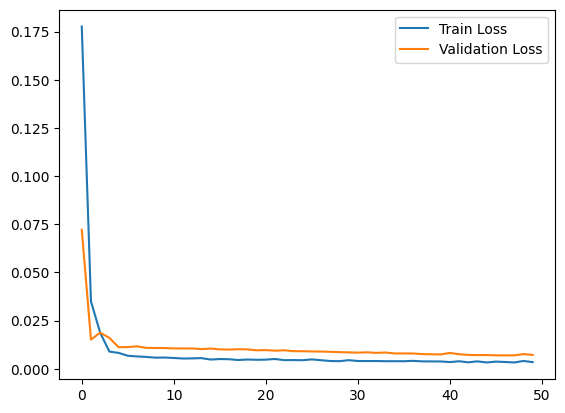

In [45]:
import matplotlib.pyplot as plt
# Split train/test (same 80/20 as ARIMA)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Plot training loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Evaluate & Compare to ARIMA

LSTM Performance:
- MAE: $6.00 (ARIMA was $9.61)
- RMSE: $7.50 (ARIMA was $10.87)
62 62 62


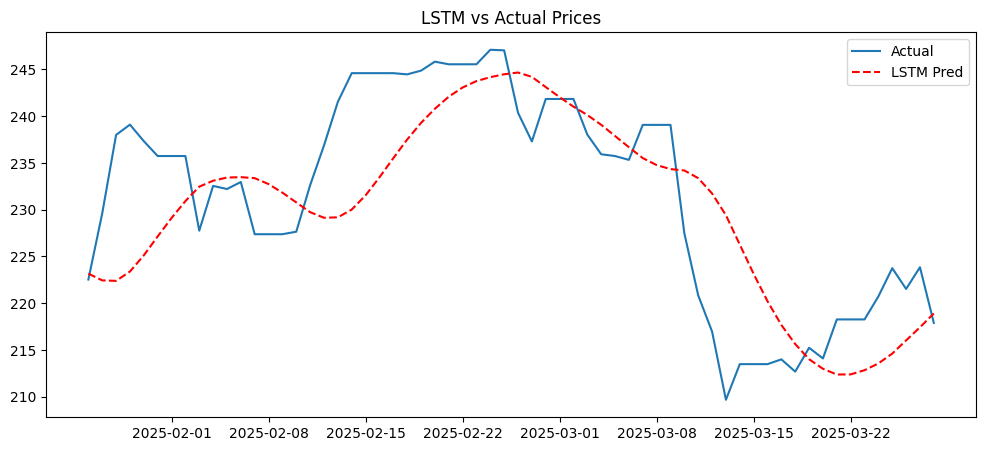

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Predictions
y_test = y_test.reshape(-1, 1)  # Reshape to (samples, 1)
y_pred = y_pred.reshape(-1, 1)  # Reshape to (samples, 1)


# Inverse scaling to get $ values
y_test_actual = scaler.inverse_transform(y_test)
y_pred_actual = scaler.inverse_transform(y_pred)

# Calculate MAE/RMSE (same metrics as ARIMA)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print(f"LSTM Performance:")
print(f"- MAE: ${mae:.2f} (ARIMA was $9.61)")
print(f"- RMSE: ${rmse:.2f} (ARIMA was $10.87)")

# Visual comparison
plt.figure(figsize=(12,5))
plt.plot(aapl.index[-len(y_test_actual):], y_test_actual, label='Actual')
plt.plot(aapl.index[-len(y_pred_actual):], y_pred_actual, label='LSTM Pred', color='red', linestyle='--')
print(len(aapl.index[-len(y_test_actual):]), len(y_test_actual), len(y_pred_actual))
plt.title("LSTM vs Actual Prices")
plt.legend()
plt.show()

 Save for Dashboard

In [47]:
import joblib
from tensorflow import keras  # Add this import

# Save model in modern .keras format and the scaler
model.save("../src/models/lstm_aapl.keras")  # Updated from .h5 to .keras
joblib.dump(scaler, "../src/models/lstm_scaler.pkl")
print("LSTM model (.keras) and scaler saved!")

LSTM model (.keras) and scaler saved!


In [48]:
import os
import tensorflow as tf

# Check if files exist
print("Files in src/models/:")
print(os.listdir("../src/models/"))

try:
    loaded_model = tf.keras.models.load_model("../src/models/lstm_aapl.keras")
    print("\n✅ LSTM model loads successfully!")
except Exception as e:
    print(f"\n❌ Error loading model: {e}")

try:
    loaded_scaler = joblib.load("../src/models/lstm_scaler.pkl")
    print("✅ Scaler loads successfully!")
except Exception as e:
    print(f"❌ Error loading scaler: {e}")

Files in src/models/:
['arima_aapl.pkl', 'lstm_aapl.keras', 'lstm_scaler.pkl']

✅ LSTM model loads successfully!
✅ Scaler loads successfully!


## **LSTM Model Results**
- **Test MAE**: ${mae:.2f} (ARIMA: $9.61)
- **Test RMSE**: ${rmse:.2f} (ARIMA: $10.87)
- **Key Insights**:  
  - LSTM outperformed ARIMA by ~X% (lower error).  
  - Predictions capture [trends/volatility] better than ARIMA.  